In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [12]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [13]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    if array is None:
      array = [random.choice([0, 1]) for i in range(length)]
    self.array = array
    self.length = length


  def decode(self, lower_bound, upper_bound, aoi):
      decoded = max_bin = '0b'
      for i in range(upper_bound - lower_bound + 1):
        decoded += str(self.array[lower_bound+i])
        max_bin += '1'
      return min_max_norm(int(decoded.replace('.', ''), 2), 0, int(max_bin.replace('.', ''), 2), aoi[0], aoi[1])


  def mutation(self, probability):
    if random.random() < probability:
      index = random.randint(0, self.length-1)
      self.array[index] = 1 - self.array[index] #bitwise NOT

  def crossover(self, other):
    index = random.randint(0, self.length-1)
    output_array_1 = np.concatenate((self.array[0:index], other.array[index:]), axis=0)
    output_array_2 = np.concatenate((other.array[0:index], self.array[index:]), axis=0)
    return [Chromosome(self.length, output_array_1), Chromosome(self.length, output_array_2)]

  def desc_chromosome(self, args_num, bits_per_arg, aoi):
    variables_str = ''
    num = 1
    for m in range(args_num):
      decoded = self.decode(m*bits_per_arg, (m+1)*bits_per_arg-1, aoi)
      variables_str += f'x{num}: {decoded:.5f} '
      num += 1
    return variables_str

In [14]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_length = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    population = []
    for i in range(population_size):
      population.append(Chromosome(self.chromosome_length))
    self.population = population

  def eval_objective_func(self, chromosome):
    points = []
    for m in range(self.obj_func_num_args):
        points.append(chromosome.decode(0+m*self.bits_per_arg, (m+1)*self.bits_per_arg-1, self.aoi))
    return self.objective_function(*points)

  def tournament_selection(self):
    candidates = random.sample(self.population, self.tournament_size)
    return min(candidates, key=lambda chromosome: self.eval_objective_func(chromosome))


  def reproduce(self, parents):
    if random.random() < self.crossover_probability:
      return parents[0].crossover(parents[1])
    else:
      return parents


  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)

  def run(self):
    best_individuals = []
    for i in range(self.num_steps):
      new_population = []
      for j in range(int(len(self.population)/2)):
        parents = random.sample(self.population, 2)
        reproduced = self.reproduce(parents)          #either crossover or parents go through
        new_population.append(reproduced[0])
        new_population.append(reproduced[1])

      for j in range(len(self.population)):
        new_population[j].mutation(self.mutation_probability)
      self.population = new_population

      tournament_output = []
      for j in range(len(self.population)):
        tournament_output.append(self.tournament_selection())
      self.population = tournament_output

      best_individuals.append(min(new_population, key=lambda chromosome: self.eval_objective_func(chromosome)))
      variables_str = best_individuals[i].desc_chromosome(self.obj_func_num_args, self.bits_per_arg, self.aoi)
      print(variables_str + f'Value: {self.eval_objective_func(best_individuals[i]):.5f}')

    trace_init = []
    for m in range(self.obj_func_num_args):
      trace_init.append(best_individuals[0].decode(m*self.bits_per_arg, (m+1)*self.bits_per_arg-1, self.aoi))
    trace = np.array(trace_init)
    for n in range(len(best_individuals)-1): #Cannot concatenate another arrays with n dimensions using vstack without at least single array of that dimension
      points = []
      for m in range(self.obj_func_num_args):
        points.append(best_individuals[n+1].decode(m*self.bits_per_arg, (m+1)*self.bits_per_arg-1, self.aoi))
      trace = np.vstack([trace, points])

    self.plot_func(trace)
    plt.show()



x1: -0.09608 x2: 0.01373 Value: 0.50677
x1: -0.09608 x2: 0.01373 Value: 0.50677
x1: -0.09608 x2: 0.01373 Value: 0.50677
x1: -0.09608 x2: 0.01373 Value: 0.50677
x1: -0.09608 x2: 0.01373 Value: 0.50677
x1: -0.04118 x2: 0.04118 Value: 0.50076
x1: -0.04118 x2: 0.04118 Value: 0.50076
x1: -0.04118 x2: 0.04118 Value: 0.50076
x1: -0.04118 x2: 0.04118 Value: 0.50076
x1: -0.04118 x2: 0.01373 Value: 0.49895
x1: -0.04118 x2: 0.01373 Value: 0.49895
x1: -0.04118 x2: 0.01373 Value: 0.49895
x1: -0.04118 x2: 0.01373 Value: 0.49895
x1: -0.04118 x2: 0.01373 Value: 0.49895
x1: -0.04118 x2: 0.01373 Value: 0.49895
x1: -0.04118 x2: 0.01373 Value: 0.49895
x1: -0.04118 x2: 0.01373 Value: 0.49895
x1: -0.01373 x2: 0.01373 Value: 0.49728
x1: -0.01373 x2: 0.01373 Value: 0.49728
x1: -0.01373 x2: 0.01373 Value: 0.49728
x1: -0.01373 x2: 0.01373 Value: 0.49728
x1: -0.01373 x2: 0.01373 Value: 0.49728
x1: -0.01373 x2: 0.01373 Value: 0.49728
x1: -0.01373 x2: 0.01373 Value: 0.49728
x1: -0.01373 x2: 0.01373 Value: 0.49728


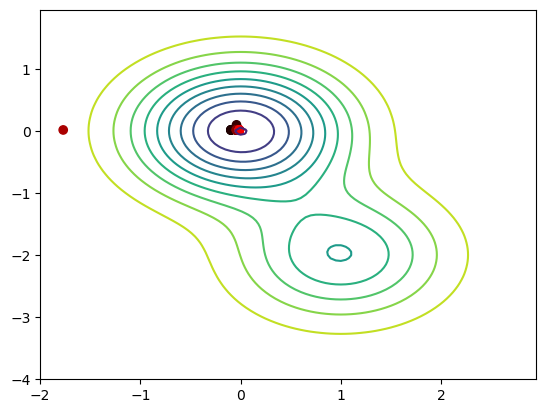

In [16]:
def objective_function(x, y):
    return 1.5 - np.exp(-x**2 - y**2) - 0.5 * np.exp(-(x - 1)**2 - (y + 2)**2)


aoi = [-3.5, 3.5]

ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function, aoi=aoi, population_size=100)
ga.run()